<a href="https://colab.research.google.com/github/zzh8829/yolov3-tf2/blob/master/colab_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YoloV3 TF2 GPU Colab Notebook

#####  Clone and install dependencies 

**IMPORTANT**: Restart following the instruction

In [1]:
#!git clone https://github.com/chrivasileiou/yolov3-tf2

# Mount drive
import sys
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd 'drive/My Drive/Colab Notebooks/build_tf_v3/yolov3-tf2/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/build_tf_v3/yolov3-tf2


In [2]:
#%load_ext tensorboard
#!pip install -U tensorboard_plugin_profile
!pip install -r requirements-gpu.txt
#!pip install -q tensorflow-model-analysis==0.21.3
#!pip install --upgrade tensorflow
#!pip install tf-nightly
#!pip install tensorflow-model-optimization
#!pip install tensorflow==2.1
#!pip install tensorflow==2.2

Obtaining file:///content/drive/My%20Drive/Colab%20Notebooks/build_tf_v3/yolov3-tf2 (from -r requirements-gpu.txt (line 5))
     |████████████████████████████████| 28.7MB 110kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
  Running setup.py develop for yolov3-tf2


##### Check Tensorflow2 version

In [ ]:
import tensorflow as tf
from tensorflow.python.client import device_lib

print(tf.__version__)
#print("python: ", sys.version)
#print("Show System RAM Memory:\n")
#!cat /proc/meminfo | egrep "MemTotal*"
print("\nShow Devices:\n", str(device_lib.list_local_devices()))
if tf.__version__ != '1.15.0':
  print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2.2.0

Show Devices:
 [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3307400557619929468
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 5145589378482843538
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3121477156154922289
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11150726272
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10630420408210140112
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]
Num GPUs Available:  1


### 1.   Convert Pretrained Darknet Weights

In [ ]:
#!wget https://pjreddie.com/media/files/yolov3-tiny.weights -O data/yolov3-tiny.weights
!python convert.py \
  --tiny=True \
  --weights='./data/yolov3-tiny.weights' \
  --mixed_precision='float32' \
  --output='./checkpoints_tiny/yolov3-tiny.tf'

2020-06-04 11:42:00.385478: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-06-04 11:42:02.050777: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-06-04 11:42:02.074821: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-06-04 11:42:02.075464: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1680] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P4 computeCapability: 6.1
coreClock: 1.1135GHz coreCount: 20 deviceMemorySize: 7.43GiB deviceMemoryBandwidth: 178.99GiB/s
2020-06-04 11:42:02.075512: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-06-04 11:42:02.076985: I tensorflow/stream_executor/platform/defaul

### 2.   Fire and Smoke Detection

##### 2.1. Prepare Fire-Smoke Dataset

In [ ]:
!touch './my_data/fire_smoke_raw/FIRESMOKEdevkit/FIRESMOKE2020/ImageSets/Main/a-file.txt'
!ls './my_data/fire_smoke_raw/FIRESMOKEdevkit/FIRESMOKE2020/Annotations/' | while IFS='.' read name type ; do echo "$name -1"; done >'./my_data/fire_smoke_raw/FIRESMOKEdevkit/FIRESMOKE2020/ImageSets/Main/a-file.txt'
!wc -l './my_data/fire_smoke_raw/FIRESMOKEdevkit/FIRESMOKE2020/ImageSets/Main/a-file.txt'
!mv './my_data/fire_smoke_raw/FIRESMOKEdevkit/FIRESMOKE2020/ImageSets/Main/a-file.txt' './my_data/fire_smoke_raw/FIRESMOKEdevkit/FIRESMOKE2020/ImageSets/Main/2_all_train.txt' && cp './my_data/fire_smoke_raw/FIRESMOKEdevkit/FIRESMOKE2020/ImageSets/Main/2_all_train.txt' './my_data/fire_smoke_raw/FIRESMOKEdevkit/FIRESMOKE2020/ImageSets/Main/2_all_val.txt'

213 ./my_data/fire_smoke_raw/FIRESMOKEdevkit/FIRESMOKE2020/ImageSets/Main/a-file.txt


In [ ]:
!python ./tools/fire_smoke_tfrecord.py \
  --data_dir './my_data/fire_smoke_raw/FIRESMOKEdevkit/FIRESMOKE2020' \
  --split train \
  --classes ./my_data/classes.names \
  --output_file ./my_data/fire_smoke_train.tfrecord \
  --emphasized_class 'all' \
  --excluded_name 'captures'
  
!python ./tools/fire_smoke_tfrecord.py \
  --data_dir './my_data/fire_smoke_raw/FIRESMOKEdevkit/FIRESMOKE2020' \
  --split val \
  --classes ./my_data/classes.names \
  --output_file ./my_data/fire_smoke_val.tfrecord \
  --emphasized_class 'all' \
  --excluded_name 'captures'

2020-07-11 10:49:02.564099: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
I0711 10:49:04.517146 139803162339200 fire_smoke_tfrecord.py:97] Class mapping loaded: {'fire': 0, 'smoke': 1}
I0711 10:49:05.345807 139803162339200 fire_smoke_tfrecord.py:102] Image list loaded: 112
100% 112/112 [00:00<00:00, 236.84it/s]
I0711 10:49:05.822666 139803162339200 fire_smoke_tfrecord.py:113] Done
2020-07-11 10:49:08.524721: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
I0711 10:49:10.479592 139804884129664 fire_smoke_tfrecord.py:97] Class mapping loaded: {'fire': 0, 'smoke': 1}
I0711 10:49:11.183451 139804884129664 fire_smoke_tfrecord.py:102] Image list loaded: 72
100% 72/72 [00:00<00:00, 220.69it/s]
I0711 10:49:11.513903 139804884129664 fire_smoke_tfrecord.py:113] Done


2020-05-29 11:54:42.937848: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
I0529 11:54:44.667838 140678598571904 visualize_dataset.py:20] classes loaded
2020-05-29 11:54:44.669385: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-05-29 11:54:44.682232: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-05-29 11:54:44.682812: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2020-05-29 11:54:44.682855: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library

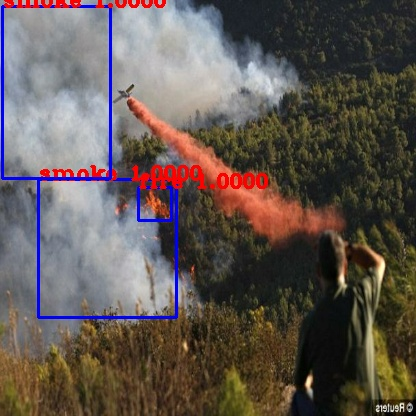

In [ ]:
!python ./tools/visualize_dataset.py \
  --dataset ./my_data/fire_smoke_train.tfrecord \
  --classes=./my_data/classes.names
from IPython.display import Image
Image(filename='./output.jpg')

##### 2.2. Export Yolo(9) and YoloV3Tiny(6) Anchors

In [ ]:
!python3 ./tools/export_anchors_kmeans.py \
  --tiny=True \
  --data_dir='./my_data/fire_smoke_raw/FIRESMOKEdevkit/FIRESMOKE2020/' \
  --classes='./my_data/classes.names' \
  --output='./my_data/anchors_tiny.txt'

2020-07-27 09:24:58.833414: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
dataset: 
	./my_data/fire_smoke_raw/FIRESMOKEdevkit/FIRESMOKE2020/ 


I0727 09:25:02.215079 140601174402944 export_anchors_kmeans.py:26] 2 classes read!
100% 213/213 [01:28<00:00,  2.41it/s]
(502, 2)
(502, 1)
cluster's centers of anchors: 
[[0.06305583 0.07758628]
 [0.28625993 0.33045896]
 [0.13212425 0.16682359]
 [0.14898325 0.43922388]
 [0.35866726 0.62231591]
 [0.11995831 0.28673327]]
X:
[[  7.80919508  19.65400297]
 [ 15.01768285  13.64861317]
 [ 51.0601217  135.94018718]
 ...
 [ 31.83748765  56.23228626]
 [ 22.22617062  31.66478255]
 [ 53.46295095  58.9620089 ]]
centers:
[[ 23.02988356  25.75354574]
 [104.55072746 109.69065305]
 [ 48.2557453   55.3744685 ]
 [ 54.41315768 145.79345758]
 [130.99606194 206.56797718]
 [ 43.81237964  95.17659843]]

sorted anchors: 
[[ 23  26]
 [ 48  55]
 [ 44  95]
 [ 54 146]
 [105 110]
 [131 207]]
X:
[[  7.80

##### 2.3.   Train Fire-Smoke detection Yolo


In [ ]:
!python train.py \
  --size=416 \
  --tiny=True \
  --dataset ./my_data/fire_smoke_train.tfrecord \
  --val_dataset ./my_data/fire_smoke_val.tfrecord \
  --classes ./my_data/classes.names \
  --num_classes=2 \
  --mixed_precision='float32' \
  --pretrained_mixed_precision='float32' \
  --pretrained_weights_num_classes 80 \
  --weights ./checkpoints_tiny/edge-tpu.tf \
  --output_weights ./checkpoints_tiny/edge-tpu.tf \
  --pdetails=True \
  --mode='eager_fit' \
  --transfer='fine_tune' \
  --batch_size=16 \
  --learning_rate=1e-3 \
  --epochs=100 \
  --ignore_thresh=0.5 \
  --accelerator='GPU' \
  --anchorstxt=./my_data/anchors_tiny.txt \
  --metrics=True \
  --log_output_fit='logs/edge-tpu' \
  --edge_tpu=True \
  --binary_class_loss=False

2020-07-29 12:42:12.666401: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-07-29 12:42:14.885877: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-07-29 12:42:14.909163: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-07-29 12:42:14.909928: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2020-07-29 12:42:14.909989: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-07-29 12:42:14.911760: I tensorflow/stream_executor/platform/defa

In [ ]:
!python train.py \
  --size=416 \
  --tiny=True \
  --dataset ./data/voc_train.tfrecord \
  --val_dataset ./data/voc_val.tfrecord \
  --classes ./data/voc2012.names \
  --num_classes=20 \
  --mixed_precision='float32' \
  --pretrained_mixed_precision='float32' \
  --pretrained_weights_num_classes 80 \
  --weights ./checkpoints_tiny/yolov3-tiny-voc.tf \
  --output_weights ./checkpoints_tiny/deleteme.tf \
  --pdetails=True \
  --mode='eager_fit' \
  --transfer='fine_tune' \
  --batch_size=16 \
  --learning_rate=1e-3 \
  --epochs=1 \
  --ignore_thresh=0.5 \
  --accelerator='GPU' \
  --anchorstxt=./data/anchors_tiny.txt \
  --metrics=True \
  --log_output_fit='logs/deleteme' \
  --edge_tpu=False \
  --binary_class_loss=False

2020-07-28 13:33:58.556219: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-07-28 13:34:00.295256: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-07-28 13:34:00.337599: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-07-28 13:34:00.338216: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s
2020-07-28 13:34:00.338258: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-07-28 13:34:00.339790: I tensorflow/stream_executor/platform/default

##### 2.4. Analyzing using Tensorboard

In [ ]:
%load_ext tensorboard
!pip install -U tensorboard_plugin_profile

     |████████████████████████████████| 1.1MB 4.5MB/s 


In [ ]:
#%tensorboard --logdir=./logs/last-fire-20200727-215743
#!kill 408

In [ ]:
#%tensorboard --logdir=./logs/last-fire-20200727-210655
#!kill 548

In [ ]:
#%tensorboard --logdir=./logs/last-fire-20200728-185026
#!kill 3448

In [ ]:
#%tensorboard --logdir=./logs/edge-tpu-20200729-121135
!kill 1156

In [ ]:
#%tensorboard --logdir=./logs/edge-tpu-20200729-124219
!kill 404 

##### 2.5. Initialize Detector

In [3]:
import sys
from absl import app, logging, flags
from absl.flags import FLAGS
import time
import tensorflow as tf
from IPython.display import Image, display
import yolov3_tf2.models as models
import yolov3_tf2.utils as utils

flags.DEFINE_boolean('tiny', False, 'yolov3 or yolov3-tiny')
flags.DEFINE_string('classes', './my_data/classes.names', 'path to classes file')
flags.DEFINE_string('weights', './checkpoints/yolov3_firedetect.tf',
                    'path to weights file')
flags.DEFINE_string('pretrained_mixed_precision', 'float32', 'pretrained weights are quantized or not. if not, they will be transformed considering the value of `quantized` ')
flags.DEFINE_integer('size', 416, 'resize images to')
flags.DEFINE_string('image', './my_data/resized_images_43.jpg', 'path to input image')
flags.DEFINE_string('output', './output.jpg', 'path to output image')
flags.DEFINE_integer('num_classes', 2, 'number of classes in the model')

app._run_init(['yolov3'], app.parse_flags_with_usage)

#physical_devices = tf.config.experimental.list_physical_devices('TPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

['yolov3']

##### 2.6. FIRE-SMOKE Detect 

I0801 19:58:23.646292 139721820686208 <ipython-input-5-d774d48e3332>:35] weights loaded
I0801 19:58:23.846785 139721820686208 utils.py:205] classes loaded


Model: "yolov3_tiny"
________________________________________________________________________________________________________________________________________________________________________________________________________
Layer (type)                                                      Output Shape                                Param #                 Connected to                                                      
input (InputLayer)                                                [(None, 416, 416, 3)]                       0                                                                                         
________________________________________________________________________________________________________________________________________________________________________________________________________
yolo_darknet (Model)                                              ((None, 26, 26, 256), (None, 13, 13, 1024)) 6298480                 input[0][0]                              

I0801 19:58:24.183566 139721820686208 utils.py:218] time: 30.5      ms
I0801 19:58:24.185176 139721820686208 utils.py:220] detections:
I0801 19:58:24.191341 139721820686208 utils.py:224] 	smoke, 0.9229404926300049, [0.7604519  0.20414495 0.80556405 0.24365786]
I0801 19:58:24.195280 139721820686208 utils.py:224] 	smoke, 0.8045621514320374, [0.5709587  0.19980812 0.6301361  0.24542862]
I0801 19:58:24.202367 139721820686208 utils.py:237] Interactive Python is active: <function get_ipython at 0x7f138329f8c8>


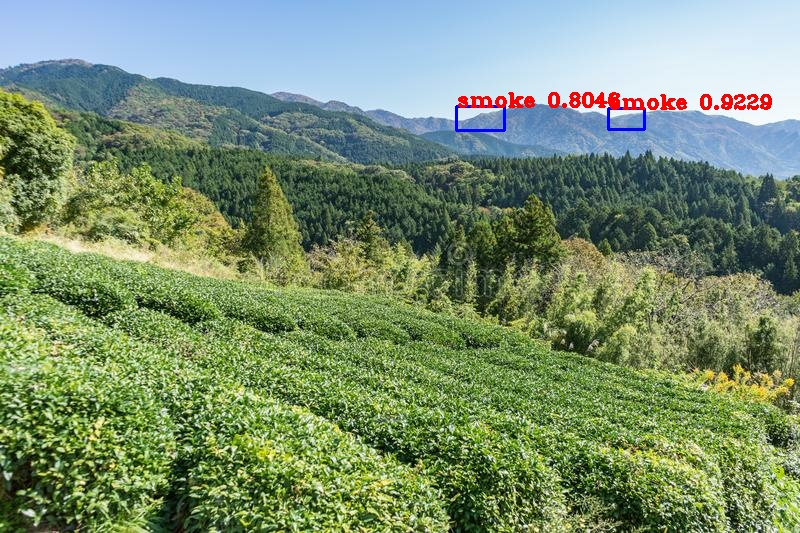

I0801 19:58:24.246549 139721820686208 utils.py:241] 
`output.jpg` extracted and it has shown up!
I0801 19:58:24.250962 139721820686208 utils.py:205] classes loaded


boxes: (1, 2535, 1, 4), scores; (1, 2535, 2)


I0801 19:58:24.317561 139721820686208 utils.py:218] time: 32.4      ms
I0801 19:58:24.318168 139721820686208 utils.py:220] detections:
I0801 19:58:24.324414 139721820686208 utils.py:224] 	smoke, 0.9229404926300049, [0.7604519  0.20414495 0.80556405 0.24365786]
I0801 19:58:24.328477 139721820686208 utils.py:224] 	smoke, 0.8045621514320374, [0.5709587  0.19980812 0.6301361  0.24542862]
I0801 19:58:24.335670 139721820686208 utils.py:237] Interactive Python is active: <function get_ipython at 0x7f138329f8c8>


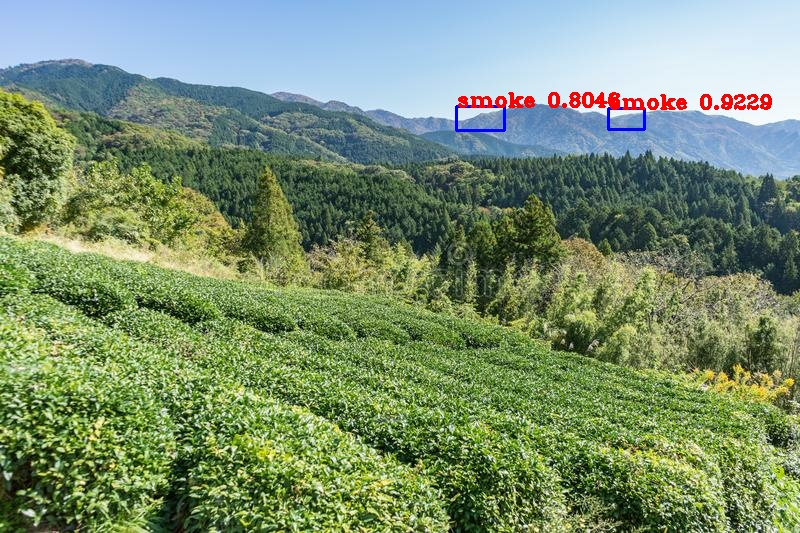

I0801 19:58:24.369558 139721820686208 utils.py:241] 
`output.jpg` extracted and it has shown up!
I0801 19:58:24.372215 139721820686208 utils.py:205] classes loaded


boxes: (1, 2535, 1, 4), scores; (1, 2535, 2)


I0801 19:58:24.437839 139721820686208 utils.py:218] time: 30.4      ms
I0801 19:58:24.438534 139721820686208 utils.py:220] detections:
I0801 19:58:24.442494 139721820686208 utils.py:224] 	smoke, 0.9229404926300049, [0.7604519  0.20414495 0.80556405 0.24365786]
I0801 19:58:24.445489 139721820686208 utils.py:224] 	smoke, 0.8045621514320374, [0.5709587  0.19980812 0.6301361  0.24542862]
I0801 19:58:24.453600 139721820686208 utils.py:237] Interactive Python is active: <function get_ipython at 0x7f138329f8c8>


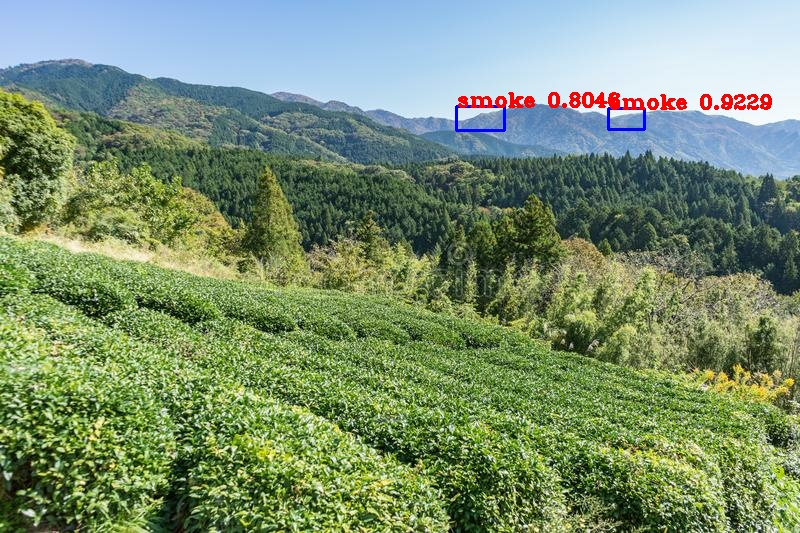

I0801 19:58:24.497368 139721820686208 utils.py:241] 
`output.jpg` extracted and it has shown up!
I0801 19:58:24.504132 139721820686208 utils.py:205] classes loaded


boxes: (1, 2535, 1, 4), scores; (1, 2535, 2)


I0801 19:58:24.567411 139721820686208 utils.py:218] time: 32.3      ms
I0801 19:58:24.568104 139721820686208 utils.py:220] detections:
I0801 19:58:24.574176 139721820686208 utils.py:224] 	smoke, 0.9229404926300049, [0.7604519  0.20414495 0.80556405 0.24365786]
I0801 19:58:24.577144 139721820686208 utils.py:224] 	smoke, 0.8045621514320374, [0.5709587  0.19980812 0.6301361  0.24542862]
I0801 19:58:24.583539 139721820686208 utils.py:237] Interactive Python is active: <function get_ipython at 0x7f138329f8c8>


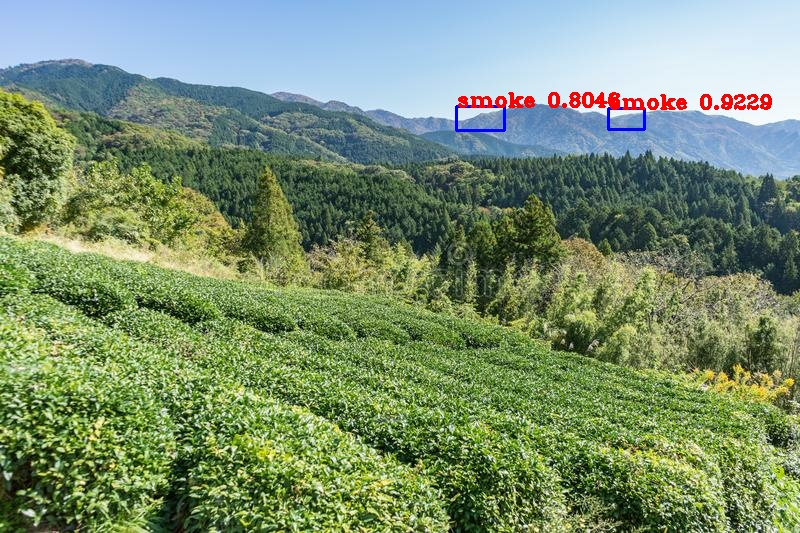

I0801 19:58:24.634893 139721820686208 utils.py:241] 
`output.jpg` extracted and it has shown up!
I0801 19:58:24.641700 139721820686208 utils.py:205] classes loaded


boxes: (1, 2535, 1, 4), scores; (1, 2535, 2)


I0801 19:58:24.708355 139721820686208 utils.py:218] time: 29.5      ms
I0801 19:58:24.708900 139721820686208 utils.py:220] detections:
I0801 19:58:24.713360 139721820686208 utils.py:224] 	smoke, 0.9229404926300049, [0.7604519  0.20414495 0.80556405 0.24365786]
I0801 19:58:24.716251 139721820686208 utils.py:224] 	smoke, 0.8045621514320374, [0.5709587  0.19980812 0.6301361  0.24542862]
I0801 19:58:24.722908 139721820686208 utils.py:237] Interactive Python is active: <function get_ipython at 0x7f138329f8c8>


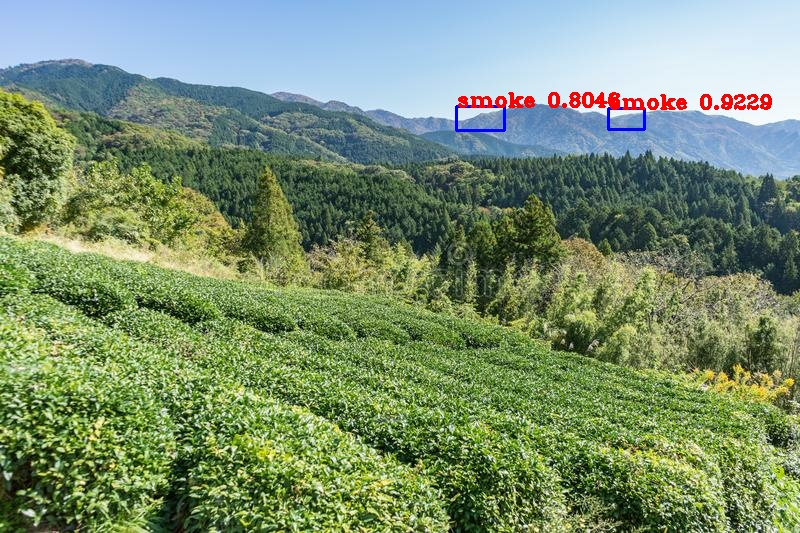

I0801 19:58:24.760692 139721820686208 utils.py:241] 
`output.jpg` extracted and it has shown up!
I0801 19:58:24.763208 139721820686208 utils.py:205] classes loaded


boxes: (1, 2535, 1, 4), scores; (1, 2535, 2)


I0801 19:58:24.834540 139721820686208 utils.py:218] time: 33.4      ms
I0801 19:58:24.835468 139721820686208 utils.py:220] detections:
I0801 19:58:24.840214 139721820686208 utils.py:224] 	smoke, 0.9229404926300049, [0.7604519  0.20414495 0.80556405 0.24365786]
I0801 19:58:24.843728 139721820686208 utils.py:224] 	smoke, 0.8045621514320374, [0.5709587  0.19980812 0.6301361  0.24542862]
I0801 19:58:24.852465 139721820686208 utils.py:237] Interactive Python is active: <function get_ipython at 0x7f138329f8c8>


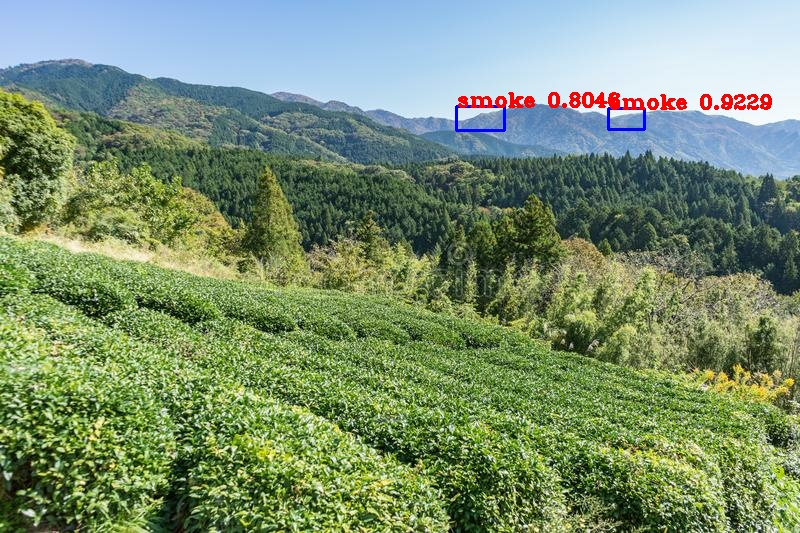

I0801 19:58:24.885409 139721820686208 utils.py:241] 
`output.jpg` extracted and it has shown up!


In [5]:
FLAGS.num_classes = 2
FLAGS.classes = './my_data/classes.names'
#FLAGS.classes = './data/voc2012.names'
#FLAGS.weights = './checkpoints_tiny/yolov3-tiny-firedetect-AllNet.tf'
FLAGS.weights = './checkpoints_tiny/yolov3-tiny-firedetect-AllNet-relu.tf'
#FLAGS.weights = './checkpoints_tiny/yolov3-tiny-voc-bc.tf'
FLAGS.size = 416
FLAGS.tiny = True
FLAGS.edge_tpu = True

# Set the image
FLAGS.image = './my_data/fire_smoke_raw/FIRESMOKEdevkit/FIRESMOKE2020/JPEGImages/resized_images_44.jpg'
#FLAGS.image = './my_data/fire_smoke_raw/FIRESMOKEdevkit/FIRESMOKE2020/JPEGImages/fire_91.jpg'
FLAGS.image = './my_data/fire_smoke_raw/FIRESMOKEdevkit/FIRESMOKE2020/JPEGImages/fire_27.jpg'
#FLAGS.image = './my_data/fire_smoke_raw/FIRESMOKEdevkit/FIRESMOKE2020/JPEGImages/flipped_resized_images_13.jpg'
#FLAGS.image = './my_data/fire_smoke_raw/FIRESMOKEdevkit/FIRESMOKE2020/JPEGImages/resized_images_13.jpg'
#FLAGS.image = './my_data/fire_started.jpg'
#FLAGS.image = './my_data/only_smoke.jpg'
FLAGS.image = './my_data/no_wildfire_2.jpg'
#FLAGS.image = './my_data/no_wildfire_9.jpg'
#FLAGS.image = './my_data/resized_images_43.jpg'
#FLAGS.image = './data/street.jpg'

# Lower threshold due to insufficient training
FLAGS.yolo_iou_threshold = 0.2
FLAGS.yolo_score_threshold = 0.8

if FLAGS.tiny:
  yolo = models.YoloV3Tiny(size=FLAGS.size, classes=FLAGS.num_classes, batch_size=None)
  #yolo = models.yolo_v3_tiny(size=FLAGS.size, classes=FLAGS.num_classes, batch_size=None)
else:
  yolo = models.YoloV3(size=FLAGS.size, classes=FLAGS.num_classes, batch_size=None)

yolo.load_weights(FLAGS.weights).expect_partial()
logging.info('weights loaded')

#utils.freeze_all(yolo)
utils.print_all_layers(yolo)
#yolo.save_weights('./checkpoints/yolo_'+str(FLAGS.size))
for i in range(6):
  utils.Inference(yolo, FLAGS.classes, FLAGS.image, size=FLAGS.size)


2020-06-18 08:13:40.201886: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-06-18 08:13:40.202036: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-06-18 08:13:40.202067: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
2020-06-18 08:13:41.472811: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-06-18 08:13:41.475655: I tensorflow/stream_executor/cuda/cuda_g

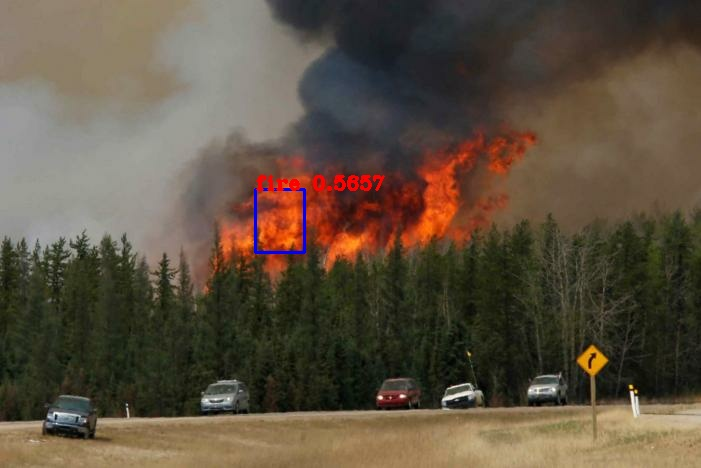

In [ ]:
python3 detect.py \
  --tiny=True \
  --weights=./checkpoints_tiny/yolov3-tiny-firedetect.tf \
  --classes=./my_data/classes.names \
  --num_classes=2 \
  --image=./my_data/fire_smoke_raw/FIRESMOKEdevkit/FIRESMOKE2020/JPEGImages/fire_91.jpg \
  --accelerator='gpu'
from IPython.display import Image
Image(filename='./output.jpg')

##### 2.7.   Export Serving & Graph

In [ ]:
!pip install tensorflow-model-optimization


     |████████████████████████████████| 174kB 5.3MB/s 
     |████████████████████████████████| 296kB 16.7MB/s 


In [ ]:
!python export_tfserving_graph.py \
  --size=416 \
  --tiny=True \
  --weights './checkpoints_tiny/yolov3-tiny-firedetect-AllNet-relu.tf' \
  --classes './my_data/classes.names' \
  --num_classes=2 \
  --batch_size=1 \
  --training=True \
  --edge_tpu=True \
  --output 'yolo_tiny_firedetect_AllNet.h5' 

2020-07-21 19:22:58.409594: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-07-21 19:23:00.180316: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-07-21 19:23:00.182676: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-07-21 19:23:00.183133: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2020-07-21 19:23:00.183175: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-07-21 19:23:00.185074: I tensorflow/stream_executor/pl

##### 2.8. Move the keras model to the correct directory. 

In [ ]:
!mv ./yolo_tiny_firedetect_AllNet.h5 ./serving/yolov3/
!echo ""
!ls -lh ./serving/yolov3/



total 1.1G
drwx------ 4 root root 4.0K May 30 09:57 firedetect_relu
drwx------ 4 root root 4.0K Jun  8 21:24 tiny-voc-relu
-rw------- 1 root root  52M Jun  9 08:27 tiny-voc-relu.h5
drwx------ 4 root root 4.0K May 20 13:26 voc
drwx------ 4 root root 4.0K Jun  3 23:00 yolo_320
-rw------- 1 root root 396M Jun  5 14:54 yolo_416.h5
drwx------ 4 root root 4.0K Jun  4 13:32 yolo_tiny_416
-rw------- 1 root root  34M Jun 18 21:50 yolo_tiny_416.h5
-rw------- 1 root root  52M Jun 24 19:37 yolo_tiny_firedetect_416.h5
-rw------- 1 root root  34M Jul 21 19:23 yolo_tiny_firedetect_AllNet.h5
-rw------- 1 root root  34M Jul  2 13:58 yolo_tiny_firedetect_metrics_416.h5
-rw------- 1 root root  34M Jun 24 18:18 yolo_tiny_voc_416.h5
-rw------- 1 root root 396M Jun 17 17:12 yolo_v3_416.h5


##### 2.9.  Export .tflite
To succesfully export .tflite file it's needed to install tensorflow-2.1 version.

In [ ]:
import tensorflow as tf
tf.__version__
!pip install tensorflow-model-optimization
!pip install tensorflow==2.1

     |████████████████████████████████| 421.8MB 40kB/s 
     |████████████████████████████████| 450kB 39.5MB/s 
     |████████████████████████████████| 3.9MB 45.2MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=538e961caf8e5877b3c11c17328e8ee2f1b863d9c0cb2ff27476e1cf583dd5f9
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Found existing installation: 

In [ ]:
import time
from absl import app, flags, logging
from absl.flags import FLAGS
import cv2
import h5py
import pathlib
import numpy as np
import tensorflow as tf
import yolov3_tf2.models as models
import yolov3_tf2.dataset as dataset
import yolov3_tf2.utils as utils
from IPython.display import Image, display
#import tensorflow_model_optimization as tfmot

flags.DEFINE_string('weights', './serving/yolov3/yolo_tiny_416.h5',
                    'path to weights file')
flags.DEFINE_string('output', 'yolov3_firedetect.tflite',
                    'path to saved_model')
flags.DEFINE_integer('size', 416, 'image size')
flags.DEFINE_integer('num_classes', 2, 'number of classes in the model')

app._run_init(['yolov3'], app.parse_flags_with_usage)


['yolov3']

In [ ]:
### It is needed to install tensorflow-2.1.0 in order to convert to .tflite
### COMMENT OUT whichever flags you want to convert. ###

# tiny
#FLAGS.weights = './serving/yolov3/yolo_tiny_firedetect_metrics_416.h5'
#FLAGS.output = 'yolov3_tiny_firedetect_relu.tflite'

# normal
#FLAGS.weights = './serving/yolov3/yolo_v3_416.h5'
#FLAGS.output = 'yolov3_firedetect_relu_edgetpu.tflite'

# tiny - tensorflow_model_optimization library. Quantizing
#FLAGS.weights = './serving/quant_yolov3/quant_yolo_tiny_firedetect_416.h5'
#FLAGS.output = 'quant_yolov3_tiny_firedetect_relu.tflite'

if 'voc' in FLAGS.weights:
  dataset_path = './data/voc2012_raw/VOCdevkit/VOC2012/JPEGImages/*'
else:
  dataset_path = './my_data/fire_smoke_raw/FIRESMOKEdevkit/FIRESMOKE2020/JPEGImages/*'

def representative_dataset_gen():
  # images in this directory
  dataset_list = tf.data.Dataset.list_files(dataset_path)
  for i, image in enumerate(dataset_list):
    if i > 100:
      break
    print(i, image)
    image = tf.io.read_file(image)
    image = tf.io.decode_image(image, channels=3)
    image = dataset.transform_images(image, FLAGS.size)
    image = tf.expand_dims(image, 0)
    yield [image]

#with tfmot.quantization.keras.quantize_scope():
#  quant_yolo = tf.keras.models.load_model(FLAGS.weights)
#quant_yolo.summary()

# Use Tensorflow 2.3
FLAGS.weights = './checkpoints_tiny/yolov3-tiny-firedetect-AllNet-relu-without-subgraph.tf'
FLAGS.output = 'firedetect-from-frozen-weights.tflite'
#FLAGS.weights = './checkpoints_tiny/edge-tpu-without-subgraph.tf'
#FLAGS.output = 'edge-tpu-from-frozen-weights.tflite'
yolo = models.yolo_v3_tiny(size=FLAGS.size, classes=FLAGS.num_classes, training=True, batch_size=1)
yolo.load_weights(FLAGS.weights).expect_partial()
yolo.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3), run_eagerly=False)
utils.freeze_all(yolo)
yolo.summary()
converter = tf.lite.TFLiteConverter.from_keras_model(yolo)
# Create the converter using keras model file
#converter = tf.compat.v1.lite.TFLiteConverter.from_keras_model_file(model_file=FLAGS.weights)
# This enables quantization
converter.optimization = [tf.lite.Optimize.DEFAULT]

# This sets the representative dataset for quantization
converter.representative_dataset = representative_dataset_gen
# EdgeTpu's builtin Ops are int8
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# For full integer quantization, though supported types defaults to int8 only, we explicitly declare it for clarity.
converter.target_spec.supported_types = [tf.int8]

# set Inputs and Outputs of network to 8-bit signed integer
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_yolo = converter.convert()
logging.info('converted')

# write model to file
tflite_yolo_dir = pathlib.Path('./checkpoints_lite/')
tflite_yolo_dir.mkdir(exist_ok=True, parents=True)
tflite_yolo_file = tflite_yolo_dir/FLAGS.output
tflite_yolo_file.write_bytes(tflite_yolo)
logging.info('Exported `{}` file in directory `./checkpoints_lite/` \n\n'.format(FLAGS.output))

Model: "yolov3_tiny"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(1, 416, 416, 3)]   0                                            
__________________________________________________________________________________________________
yolo_darknet_0_0_conv2d (Conv2D (1, 416, 416, 16)    432         input[0][0]                      
__________________________________________________________________________________________________
yolo_darknet_0_batch_norm (Batc (1, 416, 416, 16)    64          yolo_darknet_0_0_conv2d[0][0]    
__________________________________________________________________________________________________
yolo_darknet_0_LeakyReLU (Leaky (1, 416, 416, 16)    0           yolo_darknet_0_batch_norm[0][0]  
________________________________________________________________________________________

I0729 15:22:19.638164 140264959915904 builder_impl.py:775] Assets written to: /tmp/tmpip63i7af/assets
I0729 15:22:20.635067 140264959915904 lite.py:624] Using experimental converter: If you encountered a problem please file a bug. You can opt-out by setting experimental_new_converter=False


0 tf.Tensor(b'./my_data/fire_smoke_raw/FIRESMOKEdevkit/FIRESMOKE2020/JPEGImages/flipped_resized_captures-a_107.jpg', shape=(), dtype=string)
1 tf.Tensor(b'./my_data/fire_smoke_raw/FIRESMOKEdevkit/FIRESMOKE2020/JPEGImages/fire_77.jpg', shape=(), dtype=string)
2 tf.Tensor(b'./my_data/fire_smoke_raw/FIRESMOKEdevkit/FIRESMOKE2020/JPEGImages/flipped_resized_captures-b_2.jpg', shape=(), dtype=string)
3 tf.Tensor(b'./my_data/fire_smoke_raw/FIRESMOKEdevkit/FIRESMOKE2020/JPEGImages/fire_66.jpg', shape=(), dtype=string)
4 tf.Tensor(b'./my_data/fire_smoke_raw/FIRESMOKEdevkit/FIRESMOKE2020/JPEGImages/fire_19.jpg', shape=(), dtype=string)
5 tf.Tensor(b'./my_data/fire_smoke_raw/FIRESMOKEdevkit/FIRESMOKE2020/JPEGImages/fire_0.jpg', shape=(), dtype=string)
6 tf.Tensor(b'./my_data/fire_smoke_raw/FIRESMOKEdevkit/FIRESMOKE2020/JPEGImages/fire_73.jpg', shape=(), dtype=string)
7 tf.Tensor(b'./my_data/fire_smoke_raw/FIRESMOKEdevkit/FIRESMOKE2020/JPEGImages/flipped_resized_images_45.jpg', shape=(), dtype=str

I0729 15:23:01.044054 140264959915904 <ipython-input-11-23bc51624df0>:66] converted
I0729 15:23:01.075229 140264959915904 <ipython-input-11-23bc51624df0>:73] Exported `firedetect-from-frozen-weights.tflite` file in directory `./checkpoints_lite/` 




In [ ]:
!ls -lh ./checkpoints_lite/

total 34M
-rw------- 1 root root   91 Apr 21 09:13 checkpoint
-rw------- 1 root root 8.4M Jun 24 19:53 yolov3_tiny_firedetect_relu_NOTsupportedTypesInt8.tflite
-rw------- 1 root root 8.4M Jul  2 14:05 yolov3_tiny_firedetect_relu.tflite
-rw------- 1 root root 8.5M Jun 24 20:02 yolov3_tiny_voc_relu_NOTsupportedTypesInt8.tflite
-rw------- 1 root root 8.5M Jun 24 19:42 yolov3_tiny_voc_relu.tflite


In [ ]:
!python export_tflite.py \
  --weights='./serving/yolov3/yolo_tiny_416.h5' \
  --output='yolov3_tiny_firedetect_relu_edgetpu.tflite' \
  --num_classes=2


### EdgeTpu

##### Finally, we're ready to compile the model for the Edge TPU.

First download the [Edge TPU Compiler](https://coral.ai/docs/edgetpu/compiler/):

In [ ]:
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

!echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list

!sudo apt-get update

!sudo apt-get install edgetpu-compiler	

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   653  100   653    0     0  14840      0 --:--:-- --:--:-- --:--:-- 14840
OK
deb https://packages.cloud.google.com/apt coral-edgetpu-stable main
Get:1 https://packages.cloud.google.com/apt coral-edgetpu-stable InRelease [6,332 B]
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
H

##### Then, compile the model

In [ ]:
!edgetpu_compiler --help
print('\n')

!edgetpu_compiler \
  --num_segments=1 \
  --out_dir=./edgetpu/tiny-firedetect \
  ./checkpoints_lite/firedetect.tflite


Edge TPU Compiler version 14.1.317412892

Usage:
edgetpu_compiler [options] model...

Options:
-o, --out_dir <dir>
       Output the compiled model and log files to directory <dir>.
       Default is the current directory (.)
-m, --min_runtime_version <val>
       Minimum Edge TPU runtime version required by your model.
       Models are forward-compatible with new Edge TPU runtimes.
       Default: 12; Min: 10; Max: 13
-i, --intermediate_tensors <str>
        A comma-separated list of tensors you want as outputs from
        the Edge TPU custom op. All operators following these tensors
       will not be compiled for the Edge TPU but are still in the
       .tflite file and will run on the CPU. If you have multiple
       input models (for co-compilation), then separate the list of
       tensors for each model with a colon, and pass them in the
       order corresponding to the input models.
-n, --num_segments <val>
       Partition the model into [num_segments] segments.
       Defa

### 3.   TPU Google

#####   3.1. Testing tpu's initialization.

In [ ]:
import tensorflow as tf
import os

print(os.environ)
if 'COLAB_TPU_ADDR' in os.environ:
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://'+os.environ['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.experimental.TPUStrategy(resolver)
else:
  print("--- TPU is NOT connected!")



environ({'COLAB_TPU_ADDR': '10.122.26.90:8470', 'GCS_READ_CACHE_BLOCK_SIZE_MB': '16', 'CLOUDSDK_CONFIG': '/content/.config', 'CUDA_VERSION': '10.1.243', 'PATH': '/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/opt/bin', 'HOME': '/root', 'LD_LIBRARY_PATH': '/usr/local/nvidia/lib:/usr/local/nvidia/lib64', 'LANG': 'en_US.UTF-8', 'SHELL': '/bin/bash', 'LIBRARY_PATH': '/usr/local/cuda/lib64/stubs', 'CUDA_PKG_VERSION': '10-1=10.1.243-1', 'SHLVL': '1', 'GCE_METADATA_TIMEOUT': '0', 'NCCL_VERSION': '2.4.8', 'NVIDIA_VISIBLE_DEVICES': 'all', 'TF_FORCE_GPU_ALLOW_GROWTH': 'true', 'DEBIAN_FRONTEND': 'noninteractive', 'CUDNN_VERSION': '7.6.5.32', 'LAST_FORCED_REBUILD': '20200316', 'JPY_PARENT_PID': '22', 'PYTHONPATH': '/env/python', 'DATALAB_SETTINGS_OVERRIDES': '{"kernelManagerProxyPort":6000,"kernelManagerProxyHost":"172.28.0.3","jupyterArgs":["--ip=\\"172.28.0.2\\""]}', 'ENV': '/root/.bashrc', 'GLIB

INFO:tensorflow:Initializing the TPU system: grpc://10.122.26.90:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


#####   3.2. Initialize Detector

In [ ]:
from yolov3_tf2.models import yolo_tiny_anchors, yolo_tiny_anchor_masks
from PIL import Image, ImageDraw
from absl import app, logging, flags
from absl.flags import FLAGS
import tensorflow.lite as tflite
import numpy as np
import platform
import collections
import time
import os

flags.DEFINE_integer('num_classes', 2, 'define the number of classes are going to be detected')
flags.DEFINE_string('classes', './fire_data/classes_edgetpu.names', 'path to classes file')
flags.DEFINE_string('model_path', 'edgetpu-segments/yolov3_tiny_firedetect_relu_edgetpu_edgetpu.tflite',
                    'path to weights file')
flags.DEFINE_string('image', './images/fire_91.jpg', 'path to input image')
flags.DEFINE_string('output', './output.jpg', 'path to output image')
flags.DEFINE_float('score_threshold', 0.5, 'score threshold')
flags.DEFINE_float('iou_threshold', 0.5, 'iou threshold')
EDGETPU_SHARED_LIB = {
  'Linux': 'libedgetpu.so.1',
  'Darwin': 'libedgetpu.1.dylib',
  'Windows': 'edgetpu.dll'
}[platform.system()]

app._run_init(['yolov3'], app.parse_flags_with_usage)


['yolov3']

##### 3.3. TPU Library

In [ ]:
Object = collections.namedtuple('Object', ['id', 'score', 'bbox'])

class BBox(collections.namedtuple('BBox', ['xmin', 'ymin', 'xmax', 'ymax'])):
    """Bounding box.
    Represents a rectangle which sides are either vertical or horizontal, parallel
    to the x or y axis.
    """
    __slots__ = ()

    @property
    def width(self):
        """Returns bounding box width."""
        return self.xmax - self.xmin

    @property
    def height(self):
        """Returns bounding box height."""
        return self.ymax - self.ymin

    @property
    def area(self):
        """Returns bound box area."""
        return self.width * self.height

    @property
    def valid(self):
        """Returns whether bounding box is valid or not.
        Valid bounding box has xmin <= xmax and ymin <= ymax which is equivalent to
        width >= 0 and height >= 0.
        """
        return self.width >= 0 and self.height >= 0

    def scale(self, sx, sy):
        """Returns scaled bounding box."""
        return BBox(xmin=sx * self.xmin,
                    ymin=sy * self.ymin,
                    xmax=sx * self.xmax,
                    ymax=sy * self.ymax)

    def translate(self, dx, dy):
        """Returns translated bounding box."""
        return BBox(xmin=dx + self.xmin,
                    ymin=dy + self.ymin,
                    xmax=dx + self.xmax,
                    ymax=dy + self.ymax)

    def map(self, f):
        """Returns bounding box modified by applying f for each coordinate."""
        return BBox(xmin=f(self.xmin),
                    ymin=f(self.ymin),
                    xmax=f(self.xmax),
                    ymax=f(self.ymax))

    @staticmethod
    def intersect(a, b):
        """Returns the intersection of two bounding boxes (may be invalid)."""
        return BBox(xmin=max(a.xmin, b.xmin),
                    ymin=max(a.ymin, b.ymin),
                    xmax=min(a.xmax, b.xmax),
                    ymax=min(a.ymax, b.ymax))

    @staticmethod
    def union(a, b):
        """Returns the union of two bounding boxes (always valid)."""
        return BBox(xmin=min(a.xmin, b.xmin),
                    ymin=min(a.ymin, b.ymin),
                    xmax=max(a.xmax, b.xmax),
                    ymax=max(a.ymax, b.ymax))

    @staticmethod
    def iou(a, b):
        """Returns intersection-over-union value."""
        intersection = BBox.intersect(a, b)
        if not intersection.valid:
            return 0.0
        area = intersection.area
        return area / (a.area + b.area - area)

def get_interpreter_input_details(interpreter):
    input_details = interpreter.get_input_details()
    return input_details

def get_interpreter_output_details(interpreter):
    output_details = interpreter.get_output_details()
    return output_details

def set_input(interpreter, image):
  """Copies a resized and properly zero-padded image to the input tensor.
  Args:
    interpreter: Interpreter object.
    size: original image size as (width, height) tuple.
    resize: a function that takes a (width, height) tuple, and returns an RGB
      image resized to those dimensions.
  Returns:
    Actual resize ratio, which should be passed to `get_output` function.
  """
  input_details = get_interpreter_input_details(interpreter)
  batch, height, width, channels = input_details[0]['shape']
  print("input_details: \n{}".format(input_details))
  print("[batch, height, width, channels]: [{},{},{},{}]".format(batch, height, width, channels))
  #print("image.size: {}".format(image.size))
  image = image.resize((height, width), resample=Image.BICUBIC)
  nimage = np.array(image)
  scale, zero_point = input_details[0]['quantization']
  nimage[:,:] = nimage / scale + zero_point
  nimage = np.expand_dims(nimage, 0).astype(np.uint8)
  interpreter.set_tensor(input_details[0]['index'], nimage)
  scale = 1.
  return scale, scale

def load_labels(path, encoding='utf-8'):
    """Loads labels from file (with or without index numbers).
    Args:
        path: path to label file.
        encoding: label file encoding.
    Returns:
        Dictionary mapping indices to labels.
    """
    with open(path, 'r', encoding=encoding) as f:
        lines = f.readlines()
        if not lines:
            return {}

        if lines[0].split(' ', maxsplit=1)[0].isdigit():
            pairs = [line.split(' ', maxsplit=1) for line in lines]
            return {int(index): label.strip() for index, label in pairs}
        else:
            return {index: line.strip() for index, line in enumerate(lines)}

def sigmoid(x):
    return 1/(1+np.exp(-x))

def np_yolo_boxes(pred, anchors, classes, calc_loss=False):
    grid_size = np.shape(pred)[1]
    box_xy, box_wh, objectness, class_probs, _ = np.split(
        pred, (2, 4, 5, 5+classes), axis=-1)
    box_xy = box_xy[:,:,:,:].astype(np.float128)
    box_wh = box_wh[:,:,:,:].astype(np.float128)
    objectness = objectness[:,:,:,:].astype(np.float128)
    class_probs = class_probs[:,:,:,:].astype(np.float128)
    box_xy = sigmoid(box_xy)
    box_wh = box_wh
    pred_box = np.concatenate((box_xy, box_wh), axis=-1)  # original xywh for loss
    class_probs = sigmoid(class_probs)

    if calc_loss is False:
        objectness = sigmoid(objectness)
    # !!! grid[x][y] == (y, x)
    grid = np.array(np.meshgrid(np.linspace(0, grid_size-1, grid_size), np.linspace(0, grid_size-1, grid_size))).astype('float32')
    grid = np.expand_dims(np.stack([grid[0], grid[1]], axis=-1), axis=2) # [gx, gy, 1, 2]

    box_xy = (box_xy.astype('float32') + grid) / float(grid_size)
    box_wh = anchors * np.exp(box_wh)

    box_x1y1 = box_xy.astype('float32') - box_wh.astype('float32') / 2
    box_x2y2 = box_xy.astype('float32') + box_wh.astype('float32') / 2

    bbox = np.concatenate([box_x1y1.astype('float32'), box_x2y2.astype('float32')], axis=-1)
    return bbox, objectness, class_probs, pred_box

def get_interpreter_output(interpreter, quantization=True):
    output_details = get_interpreter_output_details(interpreter)
    print("output_details: \n{}\n{}".format(output_details[0], output_details[1]))
    outputs = []
    for output in output_details:
        prediction = interpreter.get_tensor(output['index'])
        if quantization:
            o_scale, o_zero = output['quantization']
            prediction = (prediction.astype(np.float32) - o_zero) * o_scale
        outputs.append(prediction)
    return outputs

def get_output(interpreter, image_scale=(1.0, 1.0), quantization=True):
    """Returns list of detected objects."""
    outputs = get_interpreter_output(interpreter, quantization=True)
    anchors = yolo_tiny_anchors
    anchor_masks = yolo_tiny_anchor_masks
    box, confidence, class_probs = [], [], []
    
    inference_time = []
    for output, mask in zip(outputs, anchor_masks):
        start = time.perf_counter()
        pred_box, pred_obj, pred_class, _ = np_yolo_boxes(output, anchors[mask], classes=FLAGS.num_classes)
        inference_time.append(time.perf_counter() - start)
        #print("pre_box: {}, {}".format(type(pred_box), pred_box.shape))
        #print("pre_obj: {}, {}".format(type(pred_obj), pred_obj.shape))
        #print("pre_class: {}, {}".format(type(pred_class), pred_class.shape))
        box.append(np.reshape(pred_box, (-1, np.shape(pred_box)[-1])))
        confidence.append(np.reshape(pred_obj, (-1, np.shape(pred_obj)[-1])))
        class_probs.append(np.reshape(pred_class, (-1, np.shape(pred_class)[-1])))

    start = time.perf_counter()
    bbox = np.column_stack([[b] for b in box])
    confidence = np.column_stack([[c] for c in confidence])
    class_probs = np.column_stack([[c] for c in class_probs])
    #print("\nbbox: {}".format(bbox.shape))
    #print("confidence: {}".format(confidence.shape))
    #print("class_probs: {}".format(class_probs.shape))

    scores = confidence * class_probs
    #scores = np.reshape(scores, (np.shape(scores)[0], -1, np.shape(scores)[-1]))
    #boxes = np.reshape(bbox, (np.shape(bbox)[0], -1, 1, 4))
    scores = np.reshape(scores, (-1, np.shape(scores)[-1]))
    boxes = np.reshape(bbox, (-1, 4))
    
    picked = combined_non_max_suppression(boxes, scores)
    #print("amax: {}\n{}".format(np.amax(scores[0][0]), scores[0][0]))

    def make(i):
        #print("Object`s box: {}".format(boxes[0][i]))
        #print("Object`s scores: {}".format(scores[0][i]))
        xmin, ymin, xmax, ymax = boxes[i]
        #ymin, xmin, ymax, xmax = boxes[i]
        return Object(
            id=np.argmax(scores[i]),
            score=np.max(scores[i]),
            bbox=BBox(xmin=xmin,
                        ymin=ymin,
                        xmax=xmax,
                        ymax=ymax))
    #mask = np.ma.masked_where(scores >= FLAGS.score_threshold, scores)
    #print("mask: {}\n{}\n".format(len(mask), mask))
    
    objs = [make(i) for i in picked]
    inference_time.append(time.perf_counter() - start)

    return objs, inference_time

def combined_non_max_suppression(boxes, scores, max_outputs=20):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
    # if the bounding boxes are integers, convert them to floats
    # It's very important since it's going to divided.
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
    # initialize the list of picked indexes
    picked = []
    # take the coordinates of the boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    
    # scores[each] = pc * [c0, c1, c2, ...] 
    # --- class_bbox: take the index of maximum element of 
    #                 scores[each], as a result it defines 
    #                 the class with highest probability of 
    #                 each bounding box
    # --- max_scores: hold the maximum element of scores[each]
    # --- order: contains in descending order the indexes
    #                       throughout the max_scores 
    bbox_class = np.argmax(scores, axis=-1)
    scores_max = np.max(scores, axis=-1)
    order = list(scores_max.argsort()[::-1])
    # compute the area of the bounding boxes and sort the bounding boxes by
    # the score confidence of the bounding box
    area = (x2-x1+1)*(y2-y1+1)
    #print("\norder size: \n{}\norder:\n{}\n".format(order.size, order))
    # keep looping while sime indexes still remain in the indexes list
    while len(order) > 0:
        if len(picked) > max_outputs:
            break
        # pick the bbox with highest score and remove it from the list
        pick = order.pop()
        if scores_max[pick] < score_threshold:
            continue
        
        picked.append(pick)
        # find the largest (x,y) coordinates for the start of the bounding box
        # and the smallest (x,y) coordinates for the end of the bounding box
        xx1 = np.maximum(x1[pick], x1[order[0:]])
        yy1 = np.maximum(y1[pick], y1[order[0:]])
        xx2 = np.minimum(x2[pick], x2[order[0:]])
        yy2 = np.minimum(y2[pick], y2[order[0:]])

        # Compute the width, height and intersection of the bounding box
        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        intersection = w*h

        # Compute the ratio of overlap
        overlap = intersection / (area[pick] + area[order[0:]] - intersection)

        # Eliminate the boxes with overlap higher than threshold 
        idxs = overlap <= iou_threshold
        order = np.array(order)
        order = list(order[idxs])
    
    return picked

def draw_objects(draw, objs, labels, size, color_map={0:'red', 1:'green'}):
  """Draws the bounding box and label for each object."""
  x, y = size[0], size[1]
  print("x,y: \n\t{}, {}\n".format(x,y))
  for obj in objs:
    bbox = obj.bbox
    draw.rectangle([(bbox.xmin*x, bbox.ymin*y), 
                    (bbox.xmax*x, bbox.ymax*y)],
                   outline=color_map[obj.id])
    draw.text((bbox.xmin*x - 10, bbox.ymin*y - 10),
              '%s\n%.2f' % (labels.get(obj.id, obj.id), obj.score),
              fill=color_map[obj.id])
    

##### 3.4. TPU Detect

In [ ]:

#FLAGS.model_path = './checkpoints_lite/yolov3_tiny_firedetect_relu_edgetpu.tflite'
FLAGS.model_path = './checkpoints_lite/yolov3_tiny_firedetect_relu_supportedTypeInt8_edgetpu.tflite'
FLAGS.classes = './my_data/classes_edgetpu.names'
FLAGS.image = './my_data/fire_91.jpg'
FLAGS.score_threshold = 0.25
FLAGS.iou_threshold = 0.25

def make_interpreter(model_file, edge_tpu=True):
    model_file, *device = model_file.split('@')
    if edge_tpu:
        return tflite.Interpreter(
          model_path=model_file,
          experimental_delegates=[
              tflite.load_delegate(EDGETPU_SHARED_LIB,
                                  {'device': device[0]} if device else {})
          ])
    else:
        return tflite.Interpreter(model_file)

interpreter = make_interpreter(FLAGS.model_path, edge_tpu=False)
interpreter.allocate_tensors()

labels = load_labels(FLAGS.classes)
image = Image.open(FLAGS.image)
scale = set_input(interpreter, image)

print("scale: {}\n".format(scale))
print('----INFERENCE TIME----')
print('Note: The first inference is slow because it includes',
    'loading the model into Edge TPU memory.\n')

for _ in range(3):
    start = time.perf_counter()
    interpreter.invoke()
    inference_time = time.perf_counter() - start
    objs, inf_time = get_output(interpreter, scale)
    inference_time += inf_time[0] + inf_time[1] + inf_time[2]
    print("\nobjs: {}\n{}".format(len(objs), type(objs)))
    print('%.3f ms' % (inference_time*1000))
    print("picked: \n{}".format(objs))

print('-------RESULTS--------')
if not objs:
    print('No objects detected')
print(labels)
for obj in objs:
    print(labels.get(obj.id, obj.id))
    print('  id:    ', obj.id)
    print('  score: ', obj.score)
    print('  bbox:  ', obj.bbox)

image = image.convert('RGB')
draw_objects(ImageDraw.Draw(image), objs, labels, image.size)
image.save('./tpu_output.jpg')


input_details: 
[{'name': 'input', 'index': 49, 'shape': array([  1, 416, 416,   3], dtype=int32), 'shape_signature': array([  1, 416, 416,   3], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.0065440163016319275, 40), 'quantization_parameters': {'scales': array([0.00654402], dtype=float32), 'zero_points': array([40], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[batch, height, width, channels]: [1,416,416,3]
scale: (1.0, 1.0)

----INFERENCE TIME----
Note: The first inference is slow because it includes loading the model into Edge TPU memory.

output_details: 
{'name': 'Identity', 'index': 50, 'shape': array([ 1, 13, 13,  3,  7], dtype=int32), 'shape_signature': array([ 1, 13, 13,  3,  7], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.00018770825408864766, 110), 'quantization_parameters': {'scales': array([0.00018771], dtype=float32), 'zero_points': array([110], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': 

In [ ]:
#print(type(tflite_results), '\n', tflite_results.shape)
tflite_results = []
for output in output_details:
  print(output)
  tflite_results.append(interpreter.get_tensor(output['index']))
#print(interpreter.get_tensor(output_details[0]['index']))
#print(interpreter.get_tensor(output_details[1]))
#print(interpreter.get_tensor(output_details[2]))

anchors = models.yolo_anchors
anchor_masks = models.yolo_anchor_masks
box, confidence, class_probs = [], [], []

for results, mask in zip(tflite_results, anchor_masks):
  print(results.shape)
  print(mask)
  print(anchors[mask])
  pred_box, pred_obj, pred_class, _ = models.yolo_boxes(results, anchors[mask], classes=FLAGS.num_classes)
  print(pred_box.shape)
  print(pred_obj.shape)
  print(pred_class.shape)
  print()
  box.append(tf.reshape(pred_box, (tf.shape(pred_box)[0], -1, tf.shape(pred_box)[-1])))
  confidence.append(tf.reshape(pred_obj, (tf.shape(pred_obj)[0], -1, tf.shape(pred_obj)[-1])))
  class_probs.append(tf.reshape(pred_class, (tf.shape(pred_class)[0], -1, tf.shape(pred_class)[-1])))

FLAGS.yolo_iou_threshold = 0.1
FLAGS.yolo_score_threshold = 0.1
bbox = tf.concat(box, axis=1)
confidence = tf.concat(confidence, axis=1)
class_probs = tf.concat(class_probs, axis=1)
scores = confidence * class_probs
boxes = tf.reshape(bbox, (tf.shape(bbox)[0], -1, 1, 4))
scores = tf.reshape(scores, (tf.shape(scores)[0], -1, tf.shape(scores)[-1]))
boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
        boxes=boxes,
        scores=scores,
        max_output_size_per_class=FLAGS.yolo_max_boxes,
        max_total_size=FLAGS.yolo_max_boxes,
        iou_threshold=FLAGS.yolo_iou_threshold,
        score_threshold=FLAGS.yolo_score_threshold
    )

with open(FLAGS.classes) as f:
    class_names = [c.strip() for c in f.readlines()]
logging.info('classes loaded')

logging.info('detections:')
for i in range(valid_detections[0]):
  logging.info("\t{}, {}, {}".format(class_names[int(classes[0][i])],
                                  scores[0][i].numpy(),
                                  boxes[0][i].numpy()))
img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
img = utils.draw_outputs(img, (boxes, scores, classes, valid_detections), class_names)

output_scale=1.
display(Image(data=bytes(cv2.imencode('.jpg', img)[1]), width=output_scale))
cv2.imwrite('./output.jpg', img)
  

NameError: ignored

#####   3.5. Create and Train the model.

In [ ]:
anchors = np.array([(30, 25), (43, 60), (51, 101), (98, 69), 
                                (63, 147), (121, 131), (99, 208), (173, 250), (306, 176)],
                                 np.float32) / 416
                                 
anchor_masks = [[6,7,8], [3,4,5], [0,1,2]]

print(os.environ)
if 'COLAB_TPU_ADDR' in os.environ:
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://'+os.environ['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.experimental.TPUStrategy(resolver)
elif 'COLAB_GPU' in os.environ:
  physical_devices = tf.config.experimental.list_physical_devices('GPU')
  for physical_device in physical_devices:
      if not tf.config.experimental.get_memory_growth(physical_device):
          tf.config.experimental.set_memory_growth(physical_device, True)
  tf.config.set_visible_devices(physical_devices, 'GPU')
  logical_devices = tf.config.list_logical_devices('GPU')
  assert len(logical_devices) == len(physical_devices)
  logging.info("Synchronous Execution: \n{}".format(tf.config.experimental.get_synchronous_execution()))
  logging.info('--- GPU is ready! ---')
else:
  print("--- Accelerator is NOT connected! ---")

train_dataset = dataset.load_tfrecord_dataset('./my_data/final_fire_smoke_train.tfrecord', FLAGS.classes, FLAGS.size)
train_dataset = train_dataset.shuffle(buffer_size=256, reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(8)
train_dataset = train_dataset.map(lambda x, y: (
    dataset.transform_images(x, FLAGS.size),
    dataset.transform_targets(y, anchors, anchor_masks, FLAGS.size)
))
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = dataset.load_tfrecord_dataset('./my_data/final_fire_smoke_val.tfrecord', FLAGS.classes, FLAGS.size)
val_dataset = val_dataset.batch(8)
val_dataset = val_dataset.map(lambda x, y: (
    dataset.transform_images(x, FLAGS.size),
    dataset.transform_targets(y, anchors, anchor_masks, FLAGS.size)
))

environ({'NO_GCE_CHECK': 'True', 'GCS_READ_CACHE_BLOCK_SIZE_MB': '16', 'CLOUDSDK_CONFIG': '/content/.config', '__EGL_VENDOR_LIBRARY_DIRS': '/usr/lib64-nvidia:/usr/share/glvnd/egl_vendor.d/', 'CUDA_VERSION': '10.1.243', 'PATH': '/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/opt/bin', 'HOME': '/root', 'LD_LIBRARY_PATH': '/usr/lib64-nvidia', 'LANG': 'en_US.UTF-8', 'SHELL': '/bin/bash', 'LIBRARY_PATH': '/usr/local/cuda/lib64/stubs', 'CUDA_PKG_VERSION': '10-1=10.1.243-1', 'SHLVL': '1', 'GCE_METADATA_TIMEOUT': '0', 'NCCL_VERSION': '2.4.8', 'NVIDIA_VISIBLE_DEVICES': 'all', 'TF_FORCE_GPU_ALLOW_GROWTH': 'true', 'DEBIAN_FRONTEND': 'noninteractive', 'CUDNN_VERSION': '7.6.5.32', 'LAST_FORCED_REBUILD': '20200430', 'JPY_PARENT_PID': '25', 'PYTHONPATH': '/env/python', 'DATALAB_SETTINGS_OVERRIDES': '{"kernelManagerProxyPort":6000,"kernelManagerProxyHost":"172.28.0.3","jupyterArgs":["--ip=\\"172.28.0.2

I0507 16:51:57.237322 140238742087552 <ipython-input-3-cc24a763a654>:21] Synchronous Execution: 
True
I0507 16:51:57.240865 140238742087552 <ipython-input-3-cc24a763a654>:22] --- GPU is ready! ---


In [ ]:

FLAGS.weights='./checkpoints/yolov3_firedetect_3.tf'
#with strategy.scope():
yolo = models.YoloV3(size=FLAGS.size, classes=FLAGS.num_classes, 
                     training=True, mixed_precision=FLAGS.mixed_precision,
                     fire_anchors=True)
yolo.load_weights(FLAGS.weights)
anchors = models.adjust_yolo_anchors(anchors, FLAGS.size)
optimizer = tf.keras.optimizers.Adam(lr=1e-3)
loss = [models.YoloLoss(anchors[mask], classes=FLAGS.num_classes)
        for mask in anchor_masks]
yolo.compile(optimizer=optimizer, loss=loss, metrics=[['accuracy'], ['accuracy'], ['accuracy']],
                      run_eagerly=True)
callbacks = [
              ModelCheckpoint('checkpoints/yolov3_deleteme', verbose=1, save_best_only=True),
              TensorBoard(log_dir='logs')
              ]
              
yolo.fit(train_dataset, epochs=20, callbacks=callbacks, validation_data=val_dataset, workers=2)
#utils.Inference(yolo, FLAGS.classes, FLAGS.image)
  

Epoch 1/20
     10/Unknown - 19s 2s/step - loss: 60.0380 - yolo_output_0_loss: 11.4504 - yolo_output_1_loss: 16.2699 - yolo_output_2_loss: 25.7712 - yolo_output_0_accuracy: 0.0553 - yolo_output_1_accuracy: 0.1432 - yolo_output_2_accuracy: 0.0984
Epoch 00001: val_loss improved from inf to 64142574867428933632.00000, saving model to checkpoints/yolov3_deleteme
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


W0507 17:01:45.003154 140238742087552 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: checkpoints/yolov3_deleteme/assets


I0507 17:01:57.837331 140238742087552 builder_impl.py:775] Assets written to: checkpoints/yolov3_deleteme/assets


10/10 [==============================] - 92s 9s/step - loss: 60.0380 - yolo_output_0_loss: 11.4504 - yolo_output_1_loss: 16.2699 - yolo_output_2_loss: 25.7712 - yolo_output_0_accuracy: 0.0553 - yolo_output_1_accuracy: 0.1432 - yolo_output_2_accuracy: 0.0984 - val_loss: 64142574867428933632.0000 - val_yolo_output_0_loss: 40971642745537953792.0000 - val_yolo_output_1_loss: 2406894724876075008.0000 - val_yolo_output_2_loss: 20764032998968393728.0000 - val_yolo_output_0_accuracy: 0.3328 - val_yolo_output_1_accuracy: 0.2932 - val_yolo_output_2_accuracy: 2.4655e-04
Epoch 2/20
10/10 [==============================] - ETA: 0s - loss: 59.8235 - yolo_output_0_loss: 9.6176 - yolo_output_1_loss: 12.7102 - yolo_output_2_loss: 22.4889 - yolo_output_0_accuracy: 0.4094 - yolo_output_1_accuracy: 0.1438 - yolo_output_2_accuracy: 0.1264 
Epoch 00002: val_loss did not improve from 64142574867428933632.00000
10/10 [==============================] - 30s 3s/step - loss: 59.8235 - yolo_output_0_loss: 9.6176 -

I0507 17:05:09.944109 140238742087552 builder_impl.py:775] Assets written to: checkpoints/yolov3_deleteme/assets


10/10 [==============================] - 92s 9s/step - loss: 75.1637 - yolo_output_0_loss: 4.9030 - yolo_output_1_loss: 22.4029 - yolo_output_2_loss: 19.7602 - yolo_output_0_accuracy: 0.2967 - yolo_output_1_accuracy: 0.0265 - yolo_output_2_accuracy: 0.0186 - val_loss: 12985413743453143040.0000 - val_yolo_output_0_loss: 12418546230102065152.0000 - val_yolo_output_1_loss: 566204713997959168.0000 - val_yolo_output_2_loss: 661527371710464.0000 - val_yolo_output_0_accuracy: 0.5962 - val_yolo_output_1_accuracy: 0.0022 - val_yolo_output_2_accuracy: 0.0870
Epoch 6/20
10/10 [==============================] - ETA: 0s - loss: 62.6127 - yolo_output_0_loss: 4.9753 - yolo_output_1_loss: 10.9577 - yolo_output_2_loss: 18.9463 - yolo_output_0_accuracy: 0.3161 - yolo_output_1_accuracy: 0.0408 - yolo_output_2_accuracy: 0.0089
Epoch 00006: val_loss improved from 12985413743453143040.00000 to 3728602843578368.00000, saving model to checkpoints/yolov3_deleteme
INFO:tensorflow:Assets written to: checkpoints/

I0507 17:06:46.182048 140238742087552 builder_impl.py:775] Assets written to: checkpoints/yolov3_deleteme/assets


10/10 [==============================] - 93s 9s/step - loss: 62.6127 - yolo_output_0_loss: 4.9753 - yolo_output_1_loss: 10.9577 - yolo_output_2_loss: 18.9463 - yolo_output_0_accuracy: 0.3161 - yolo_output_1_accuracy: 0.0408 - yolo_output_2_accuracy: 0.0089 - val_loss: 3728602843578368.0000 - val_yolo_output_0_loss: 2670935471554560.0000 - val_yolo_output_1_loss: 1043125887827968.0000 - val_yolo_output_2_loss: 14541475807232.0000 - val_yolo_output_0_accuracy: 0.5833 - val_yolo_output_1_accuracy: 0.3249 - val_yolo_output_2_accuracy: 0.2704
Epoch 7/20
10/10 [==============================] - ETA: 0s - loss: 63.1450 - yolo_output_0_loss: 4.7822 - yolo_output_1_loss: 13.0792 - yolo_output_2_loss: 18.7518 - yolo_output_0_accuracy: 0.3209 - yolo_output_1_accuracy: 0.0371 - yolo_output_2_accuracy: 0.0134
Epoch 00007: val_loss improved from 3728602843578368.00000 to 2289443536896.00000, saving model to checkpoints/yolov3_deleteme
INFO:tensorflow:Assets written to: checkpoints/yolov3_deleteme/as

I0507 17:08:21.970731 140238742087552 builder_impl.py:775] Assets written to: checkpoints/yolov3_deleteme/assets


10/10 [==============================] - 92s 9s/step - loss: 63.1450 - yolo_output_0_loss: 4.7822 - yolo_output_1_loss: 13.0792 - yolo_output_2_loss: 18.7518 - yolo_output_0_accuracy: 0.3209 - yolo_output_1_accuracy: 0.0371 - yolo_output_2_accuracy: 0.0134 - val_loss: 2289443536896.0000 - val_yolo_output_0_loss: 1780376535040.0000 - val_yolo_output_1_loss: 495895183360.0000 - val_yolo_output_2_loss: 13171877888.0000 - val_yolo_output_0_accuracy: 0.5242 - val_yolo_output_1_accuracy: 0.3108 - val_yolo_output_2_accuracy: 0.3153
Epoch 8/20
10/10 [==============================] - ETA: 0s - loss: 64.9282 - yolo_output_0_loss: 6.8590 - yolo_output_1_loss: 13.2969 - yolo_output_2_loss: 19.6601 - yolo_output_0_accuracy: 0.3248 - yolo_output_1_accuracy: 0.0238 - yolo_output_2_accuracy: 0.0568
Epoch 00008: val_loss improved from 2289443536896.00000 to 1764590616576.00000, saving model to checkpoints/yolov3_deleteme
INFO:tensorflow:Assets written to: checkpoints/yolov3_deleteme/assets


I0507 17:09:58.438410 140238742087552 builder_impl.py:775] Assets written to: checkpoints/yolov3_deleteme/assets


10/10 [==============================] - 93s 9s/step - loss: 64.9282 - yolo_output_0_loss: 6.8590 - yolo_output_1_loss: 13.2969 - yolo_output_2_loss: 19.6601 - yolo_output_0_accuracy: 0.3248 - yolo_output_1_accuracy: 0.0238 - yolo_output_2_accuracy: 0.0568 - val_loss: 1764590616576.0000 - val_yolo_output_0_loss: 1344636190720.0000 - val_yolo_output_1_loss: 417347928064.0000 - val_yolo_output_2_loss: 2606392064.0000 - val_yolo_output_0_accuracy: 0.3712 - val_yolo_output_1_accuracy: 0.3274 - val_yolo_output_2_accuracy: 0.0352
Epoch 9/20
10/10 [==============================] - ETA: 0s - loss: 59.1927 - yolo_output_0_loss: 4.4456 - yolo_output_1_loss: 11.4469 - yolo_output_2_loss: 19.3605 - yolo_output_0_accuracy: 0.3022 - yolo_output_1_accuracy: 0.0197 - yolo_output_2_accuracy: 0.0104
Epoch 00009: val_loss improved from 1764590616576.00000 to 466969624576.00000, saving model to checkpoints/yolov3_deleteme
INFO:tensorflow:Assets written to: checkpoints/yolov3_deleteme/assets


I0507 17:11:35.573584 140238742087552 builder_impl.py:775] Assets written to: checkpoints/yolov3_deleteme/assets


10/10 [==============================] - 94s 9s/step - loss: 59.1927 - yolo_output_0_loss: 4.4456 - yolo_output_1_loss: 11.4469 - yolo_output_2_loss: 19.3605 - yolo_output_0_accuracy: 0.3022 - yolo_output_1_accuracy: 0.0197 - yolo_output_2_accuracy: 0.0104 - val_loss: 466969624576.0000 - val_yolo_output_0_loss: 432227942400.0000 - val_yolo_output_1_loss: 34504835072.0000 - val_yolo_output_2_loss: 236901536.0000 - val_yolo_output_0_accuracy: 0.3402 - val_yolo_output_1_accuracy: 0.3230 - val_yolo_output_2_accuracy: 4.9618e-04
Epoch 10/20
10/10 [==============================] - ETA: 0s - loss: 57.1412 - yolo_output_0_loss: 4.3440 - yolo_output_1_loss: 11.1625 - yolo_output_2_loss: 18.8532 - yolo_output_0_accuracy: 0.2369 - yolo_output_1_accuracy: 0.0137 - yolo_output_2_accuracy: 0.0143
Epoch 00010: val_loss improved from 466969624576.00000 to 28058660864.00000, saving model to checkpoints/yolov3_deleteme
INFO:tensorflow:Assets written to: checkpoints/yolov3_deleteme/assets


I0507 17:13:13.663660 140238742087552 builder_impl.py:775] Assets written to: checkpoints/yolov3_deleteme/assets


10/10 [==============================] - 95s 9s/step - loss: 57.1412 - yolo_output_0_loss: 4.3440 - yolo_output_1_loss: 11.1625 - yolo_output_2_loss: 18.8532 - yolo_output_0_accuracy: 0.2369 - yolo_output_1_accuracy: 0.0137 - yolo_output_2_accuracy: 0.0143 - val_loss: 28058660864.0000 - val_yolo_output_0_loss: 26805360640.0000 - val_yolo_output_1_loss: 1242846464.0000 - val_yolo_output_2_loss: 10451875.0000 - val_yolo_output_0_accuracy: 0.3376 - val_yolo_output_1_accuracy: 0.3194 - val_yolo_output_2_accuracy: 0.1756
Epoch 11/20
 9/10 [==========================>...] - ETA: 1s - loss: 55.9378 - yolo_output_0_loss: 4.3927 - yolo_output_1_loss: 10.7169 - yolo_output_2_loss: 19.1529 - yolo_output_0_accuracy: 0.0617 - yolo_output_1_accuracy: 0.0241 - yolo_output_2_accuracy: 0.0866

KeyboardInterrupt: ignored

# Informal

In [ ]:
#FLAGS.weights = './checkpoints_tiny/yolov3-tiny-firedetect-AllNet-relu.tf'
#FLAGS.output = './checkpoints_tiny/yolov3-tiny-firedetect-AllNet-relu-without-subgraph.tf'
FLAGS.weights = './checkpoints_tiny/edge-tpu.tf'
FLAGS.output = './checkpoints_tiny/edge-tpu-without-subgraph.tf'

yoloTiny = models.YoloV3Tiny(size=FLAGS.size, classes=FLAGS.num_classes, batch_size=None)
yolo_tiny = models.yolo_v3_tiny(size=FLAGS.size, classes=FLAGS.num_classes, training=True, batch_size=None)
yoloTiny.load_weights(FLAGS.weights).expect_partial()
yoloTiny.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3), run_eagerly=False)
yolo_tiny.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3), run_eagerly=False)

i = 0
for sub_model in yolo_tiny.layers:
  for submodel in yoloTiny.layers:
    if isinstance(submodel, tf.keras.Model):
      for l in submodel.layers:
        if l.name == sub_model.name:
          i+=1
          print(i, ': ', l.name, ', ', sub_model.name)
          sub_model.set_weights(l.get_weights())

#utils.Inference(yolo_tiny, FLAGS.classes, FLAGS.image, size=FLAGS.size)
yolo_tiny.save_weights(FLAGS.output)

1 :  yolo_darknet_0_0_conv2d ,  yolo_darknet_0_0_conv2d
2 :  yolo_darknet_0_batch_norm ,  yolo_darknet_0_batch_norm
3 :  yolo_darknet_0_ReLU ,  yolo_darknet_0_ReLU
4 :  yolo_darknet_MaxPool_0 ,  yolo_darknet_MaxPool_0
5 :  yolo_darknet_1_0_conv2d ,  yolo_darknet_1_0_conv2d
6 :  yolo_darknet_1_batch_norm ,  yolo_darknet_1_batch_norm
7 :  yolo_darknet_1_ReLU ,  yolo_darknet_1_ReLU
8 :  yolo_darknet_MaxPool_1 ,  yolo_darknet_MaxPool_1
9 :  yolo_darknet_2_0_conv2d ,  yolo_darknet_2_0_conv2d
10 :  yolo_darknet_2_batch_norm ,  yolo_darknet_2_batch_norm
11 :  yolo_darknet_2_ReLU ,  yolo_darknet_2_ReLU
12 :  yolo_darknet_MaxPool_2 ,  yolo_darknet_MaxPool_2
13 :  yolo_darknet_3_0_conv2d ,  yolo_darknet_3_0_conv2d
14 :  yolo_darknet_3_batch_norm ,  yolo_darknet_3_batch_norm
15 :  yolo_darknet_3_ReLU ,  yolo_darknet_3_ReLU
16 :  yolo_darknet_MaxPool_3 ,  yolo_darknet_MaxPool_3
17 :  yolo_darknet_4_0_conv2d ,  yolo_darknet_4_0_conv2d
18 :  yolo_darknet_4_batch_norm ,  yolo_darknet_4_batch_norm
19 

In [ ]:
import numpy as np
import tensorflow as tf

def combined_non_max_suppression(boxes, scores, max_outputs=20):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
    # if the bounding boxes are integers, convert them to floats
    # It's very important since it's going to divided.
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
    # initialize the list of picked indexes
    picked = []
    # take the coordinates of the boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    
    # scores[each] = pc * [c0, c1, c2, ...] 
    # --- class_bbox: take the index of maximum element of 
    #                 scores[each], as a result it defines 
    #                 the class with highest probability of 
    #                 each bounding box
    # --- max_scores: hold the maximum element of scores[each]
    # --- order: contains in descending order the indexes
    #                       throughout the max_scores 
    bbox_class = np.argmax(scores, axis=-1)
    scores_max = np.max(scores, axis=-1)
    order = list(scores_max.argsort()[::-1])
    # compute the area of the bounding boxes and sort the bounding boxes by
    # the score confidence of the bounding box
    area = (x2-x1+1)*(y2-y1+1)
    #print("\norder size: \n{}\norder:\n{}\n".format(order.size, order))
    # keep looping while sime indexes still remain in the indexes list
    while len(order) > 0:
        if len(picked) > max_outputs:
            break
        # pick the bbox with highest score and remove it from the list
        pick = order.pop()
        if scores_max[pick] < score_threshold:
            continue
        
        picked.append(pick)
        # find the largest (x,y) coordinates for the start of the bounding box
        # and the smallest (x,y) coordinates for the end of the bounding box
        xx1 = np.maximum(x1[pick], x1[order[0:]])
        yy1 = np.maximum(y1[pick], y1[order[0:]])
        xx2 = np.minimum(x2[pick], x2[order[0:]])
        yy2 = np.minimum(y2[pick], y2[order[0:]])

        # Compute the width, height and intersection of the bounding box
        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        intersection = w*h

        # Compute the ratio of overlap
        overlap = intersection / (area[pick] + area[order[0:]] - intersection)

        # Eliminate the boxes with overlap higher than threshold 
        idxs = overlap <= iou_threshold
        order = np.array(order)
        order = list(order[idxs])
    
    return picked

boxes = []
scores = []
box1 = np.random.random((1,13,13,3,4))
box2 = np.random.random((1,26,26,3,4))
scores1 = np.random.random((1,13,13,3,2))
scores2 = np.random.random((1,26,26,3,2))
boxes.append(np.reshape(box1, (-1, np.shape(box1)[-1])))
boxes.append(np.reshape(box2, (-1, np.shape(box2)[-1])))
scores.append(np.reshape(scores1, (-1, np.shape(scores1)[-1])))
scores.append(np.reshape(scores2, (-1, np.shape(scores2)[-1])))

boxes = np.column_stack([[b] for b in boxes])
scores = np.column_stack([[s] for s in scores])
boxes = np.reshape(boxes, (-1, np.shape(boxes)[-1]))
scores = np.reshape(scores, (-1, np.shape(scores)[-1]))
score_threshold = 0.5
iou_threshold = 0.5
picked = combined_non_max_suppression(boxes, scores)

print(boxes.shape) 
print(scores.shape)
bbox_class = np.argmax(scores,axis=-1)
scores_max = np.max(scores,axis=-1)
order = list(scores_max.argsort()[::-1])
print(bbox_class)
print(scores_max)
print(order)
print(order.pop(0))
print(order)
print(scores_max[order])
print('------ RESULT ------')
print(picked)


(2535, 4)
(2535, 2)
[1 1 0 ... 0 0 0]
[0.5975596  0.98810978 0.6538385  ... 0.40907048 0.47060725 0.92522793]
[776, 58, 1073, 2366, 236, 1901, 659, 2033, 1000, 773, 1871, 692, 1564, 1757, 1543, 1141, 1122, 324, 328, 1241, 195, 1260, 495, 2484, 1347, 294, 1121, 1973, 2125, 2319, 2094, 1097, 1253, 1004, 330, 429, 975, 1480, 1891, 151, 1178, 18, 24, 132, 5, 481, 266, 1860, 1, 592, 786, 420, 2220, 673, 33, 1037, 1776, 1104, 138, 1413, 793, 1765, 839, 1474, 1470, 1264, 1165, 142, 507, 543, 2385, 1531, 2306, 894, 1768, 1932, 1545, 2055, 503, 1690, 45, 1956, 2499, 2155, 505, 1043, 1665, 1148, 1763, 1220, 1401, 2120, 1990, 1238, 1252, 1079, 2290, 1349, 2113, 134, 1610, 2467, 2123, 2521, 576, 7, 1219, 823, 1946, 957, 1080, 2367, 799, 487, 1469, 621, 1572, 391, 2073, 1609, 778, 1880, 2035, 2379, 1705, 689, 1580, 2209, 443, 1279, 2095, 977, 2066, 2516, 2141, 986, 2430, 64, 1119, 1374, 2308, 836, 2067, 1321, 54, 95, 1383, 1536, 322, 1346, 1743, 173, 1242, 438, 843, 1678, 1507, 1398, 1314, 406, 860

In [ ]:
import tensorflow as tf

idx = [[[1], [0], [0]], [[0], [2], [0]], [[1], [0], [3]]]
obj = [[[1, 42], [0, 0], [0, 0]], [[0, 1], [1, 11], [0, 23]], [[0, 43], [0,55], [1,2]]]

tf_idx = tf.convert_to_tensor(idx)
tf_obj = tf.convert_to_tensor(obj)

tf_one_hot = tf.one_hot(tf_idx, 5)
mask = tf_idx == 1
for i in range(3):
  if i == 0:
    mask_2 = mask
  else:
    mask_2 = tf.concat([mask_2, mask], axis=-1)

tf.print("mask: \n{}".format(mask))
tf.print("mask_2: \n{}".format(mask_2))
tf.print("boolean_mask: \n{}".format(tf.boolean_mask(tf_idx, mask)))
tf_obj = tf.where(tf_obj >= 0.5, tf_one_hot, [0,0,0,0,0])
x = [0 for _ in range(3)]   
#tf.print("objects: \n", tf_obj)
#print('\n', x, '\n')
#tf.print("one_hot: \n", tf_one_hot)

mask: 
[[[ True]
  [False]
  [False]]

 [[False]
  [False]
  [False]]

 [[ True]
  [False]
  [False]]]
mask_2: 
[[[ True  True  True]
  [False False False]
  [False False False]]

 [[False False False]
  [False False False]
  [False False False]]

 [[ True  True  True]
  [False False False]
  [False False False]]]
boolean_mask: 
[1 1]


TypeError: ignored

In [ ]:
#!ls './my_data/fire_smoke_raw/FIRESMOKEdevkit/FIRESMOKE2020/JPEGImages/' | while IFS='.' read name type ; do echo "$name" ; done > pics
#!ls './my_data/fire_smoke_raw/FIRESMOKEdevkit/FIRESMOKE2020/Annotations/' | while IFS='.' read name type ; do echo "$name" ; done > xmls
#!CNT=0 && MYPATH="./my_data/fire_smoke_raw/FIRESMOKEdevkit/FIRESMOKE2020/JPEGImages/" && ls "$MYPATH" | while IFS='.' read name type ; do if [[ $name != *"resized"* ]] ; then mv "$MYPATH$name.$type" "$MYPATH""fire_$CNT.$type" ; CNT=$(($CNT+1)) ; fi done 
#!MYPATH="./my_data/fire_smoke_raw/FIRESMOKEdevkit/FIRESMOKE2020/JPEGImages/" && echo "$MYPATH""fire_"
#!MYPATH=./my_data/fire_smoke_raw/FIRESMOKEdevkit/FIRESMOKE2020/JPEGImages/ && ls "$MYPATH"

In [ ]:
import tensorflow as  tf
import time

iou = tf.convert_to_tensor([[[23,  454, 345], [4, 5, 43], [312, 1, 432], [1,2,3]], 
                            [[234, 3645, 3],[9, 2, 4],[435, 7, 4],[10, 4, 34]]])
iou2 = tf.cast(iou<10, tf.float32)


@tf.function()
def measure_flatten(p=False):
  flatten = tf.reshape(iou2, shape=(-1, tf.shape(iou2)[-1]))
  count= tf.cast(0, tf.int64)
  true = tf.cast(0, tf.int64)
  false = tf.cast(0, tf.int64)
  for f in flatten:
    if p:
      tf.print(f)
      ones = tf.math.count_nonzero(f)
      zeros = len(f)-ones
      if tf.math.logical_and(tf.math.greater(zeros, 0), True):
        false += ones
        true += zeros
        tf.print(count) 
  return true, false
    #tf.print(tf.math.count_nonzero(j))

@tf.function()
def measure_original(p=False):
  count= tf.cast(0, tf.int64)
  for o in iou2:
    for j in o:
      if p:
        tf.print(j)

measure_flatten()
s = time.time()
true, false = measure_flatten(p=True)
e = time.time()

if not tf.math.logical_and(tf.math.equal(true, 0), tf.math.equal(false, 0)):
  tf.print('trues: ', true, '\nfalses: ', false)
print("flatten: {} secs".format(e-s))

measure_original()
s = time.time()
measure_original(p=True)
e = time.time()
print("original: {} secs".format(e-s))

# 0x7fa77fec7200


[0 0 0]
0
[1 1 0]
0
[0 1 0]
0
[1 1 1]
[0 0 1]
0
[1 1 1]
[0 1 1]
0
[0 1 0]
0
trues:  11 
falses:  7
flatten: 0.1462249755859375 secs
[0 0 0]
[1 1 0]
[0 1 0]
[1 1 1]
[0 0 1]
[1 1 1]
[0 1 1]
[0 1 0]
original: 0.08079385757446289 secs


In [ ]:
import tensorflow as  tf
import time

y_logits = tf.convert_to_tensor([[[23,  454, 345], [4, 5, 43], [312, 1, 432], [1,2,3]], 
                            [[234, 3645, 3],[9, 2, 4],[435, 7, 4],[10, 4, 34]]], dtype=tf.float32)
y_probs = tf.sigmoid(y_logits)
bce_l = tf.keras.losses.BinaryCrossentropy(from_logits=True)
bce_p = tf.keras.losses.BinaryCrossentropy()

y_true = tf.convert_to_tensor([[[23,  454, 345], [4, 5, 43], [312, 1, 432], [1,2,3]], 
                            [[234, 3645, 3],[9, 2, 4],[435, 7, 4],[10, 4, 34]]], dtype=tf.float32)
y_true_sig = tf.sigmoid(y_true)
print("Attempt 0:\n",
      "logits: \n{}\n".format(y_logits),
      "probs: \n{}\n".format(y_probs),
      "y_true: \n{}\n".format(y_true_sig),
      "bce (logits): \n{}\n".format(bce_l(y_true_sig, y_logits)),
      "bce (probs): \n{}\n\n".format(bce_p(y_true_sig, y_probs)))
sum_logits = 0
sum_probs = 0
for i in range(5):
  y_logits = tf.convert_to_tensor([[i]], dtype=tf.float32)
  y_probs = tf.sigmoid(y_logits)

  y_true = tf.convert_to_tensor([[50]], dtype=tf.float32)
  y_true_sig = tf.sigmoid(y_true)
  loss_logits = bce_l(y_true_sig, y_logits)
  loss_probs = bce_p(y_true_sig, y_probs)
  print("Attempt {}:\n".format(i), 
        "logits: \n{}\n".format(y_logits),
        "probs: \n{}\n".format(y_probs),
        "y_true: \n{}\n".format(y_true_sig),
        "bce (logits): \n{}\n".format(loss_logits),
        "bce (probs): \n{}\n\n".format(loss_probs)
        )
  sum_logits += loss_logits
  sum_probs += loss_probs

y_logits = tf.convert_to_tensor([[0, 1, 2, 3, 4]], dtype=tf.float32)
y_probs = tf.sigmoid(y_logits)

y_true = tf.convert_to_tensor([[50, 50, 50, 50, 50]], dtype=tf.float32)
y_true_sig = tf.sigmoid(y_true)

for y_true in y_true_sig:
  tf.print(y_true)
loss_logits = bce_l(y_true_sig, y_logits)
loss_probs = bce_p(y_true_sig, y_probs)

print("Attempt final:\n", 
      "logits: \n{}\n".format(y_logits),
      "probs: \n{}\n".format(y_probs),
      "y_true: \n{}\n\n".format(y_true_sig),
      "sum_logits: \n{}\n".format(sum_logits),
      "bce (logits): \n{}\n".format(loss_logits),
      "sum_probs: \n{}\n".format(sum_probs),
      "bce (probs): \n{}\n\n".format(loss_probs)
      )


Attempt 0:
 logits: 
[[[2.300e+01 4.540e+02 3.450e+02]
  [4.000e+00 5.000e+00 4.300e+01]
  [3.120e+02 1.000e+00 4.320e+02]
  [1.000e+00 2.000e+00 3.000e+00]]

 [[2.340e+02 3.645e+03 3.000e+00]
  [9.000e+00 2.000e+00 4.000e+00]
  [4.350e+02 7.000e+00 4.000e+00]
  [1.000e+01 4.000e+00 3.400e+01]]]
 probs: 
[[[1.         1.         1.        ]
  [0.98201376 0.9933072  1.        ]
  [1.         0.7310586  1.        ]
  [0.7310586  0.880797   0.95257413]]

 [[1.         1.         0.95257413]
  [0.9998766  0.880797   0.98201376]
  [1.         0.999089   0.98201376]
  [0.9999546  0.98201376 1.        ]]]
 y_true: 
[[[1.         1.         1.        ]
  [0.98201376 0.9933072  1.        ]
  [1.         0.7310586  1.        ]
  [0.7310586  0.880797   0.95257413]]

 [[1.         1.         0.95257413]
  [0.9998766  0.880797   0.98201376]
  [1.         0.999089   0.98201376]
  [0.9999546  0.98201376 1.        ]]]
 bce (logits): 
0.11193269491195679
 bce (probs): 
0.11193259060382843


Attempt 0:


In [ ]:
from IPython.display import Image, display
import IPython
import google.colab as colab
import sys
print('google.colab' in sys.modules)
display(Image('./output'))
ipython = IPython.get_ipython()
print("IPython: {}".format(ipython))
print("IPython: {}".format(colab.load_ipython_extension(ipython)))

True


IPython: <google.colab._shell.Shell object at 0x7fc2e72d8860>


TypeError: ignored

In [ ]:
!pip install tensorflow==2.1.0

  Using cached https://files.pythonhosted.org/packages/85/d4/c0cd1057b331bc38b65478302114194bd8e1b9c2bbc06e300935c0e93d90/tensorflow-2.1.0-cp36-cp36m-manylinux2010_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/d9/41/bbf49b61370e4f4d245d4c6051dfb6db80cec672605c91b1652ac8cc3d38/tensorboard-2.1.1-py3-none-any.whl
Processing /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd/gast-0.2.2-cp36-none-any.whl
  Using cached https://files.pythonhosted.org/packages/18/90/b77c328a1304437ab1310b463e533fa7689f4bfc41549593056d812fab8e/tensorflow_estimator-2.1.0-py2.py3-none-any.whl
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found exi

In [ ]:
!g++ -std=c++11 -shared zero_out.cc -o zero_out.so -fPIC ${TF_CFLAGS[@]} ${TF_LFLAGS[@]} -O2